# Prerequisites

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Subset
import torchvision.models as models
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm

/opt/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <EEB3232B-F6A7-3262-948C-BB2F54905803> /opt/anaconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"

# Folder to save the dataset
output_folder = "data"
os.makedirs(output_folder, exist_ok=True)

# File name for the downloaded dataset
file_name = os.path.join(output_folder, "dataset.zip")

def download_file(url, output_path):
    """Download a file from a URL and save it locally."""
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"File downloaded successfully: {output_path}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

# Download the dataset
download_file(url, file_name)

In [ ]:
# Extract downloaded dataset

import zipfile

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(output_folder)
print("Dataset extracted successfully.")

In [5]:
load_dotenv()

data_path = os.environ.get('DATA_PATH')

In [6]:
total_samples = 0

for folder in os.listdir(data_path):
    print(folder, len(os.listdir(os.path.join(data_path, folder))))
    total_samples += len(os.listdir(os.path.join(data_path,folder)))

print('\n')
print('Total samples =>', total_samples)

Strawberry___healthy 1000
Grape___Black_rot 1180
Potato___Early_blight 1000
Blueberry___healthy 1502
Cherry___Powdery_mildew 1052
Tomato___Target_Spot 1404
Peach___healthy 1000
Potato___Late_blight 1000
Tomato___Late_blight 1909
Tomato___Tomato_mosaic_virus 1000
Pepper,_bell___healthy 1478
Orange___Haunglongbing_(Citrus_greening) 5507
Tomato___Leaf_Mold 1000
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) 1076
Apple___Cedar_apple_rust 1000
Tomato___Bacterial_spot 2127
Grape___healthy 1000
Corn___Cercospora_leaf_spot Gray_leaf_spot 1000
Tomato___Early_blight 1000
Grape___Esca_(Black_Measles) 1383
Raspberry___healthy 1000
Tomato___healthy 1591
Corn___Northern_Leaf_Blight 1000
Tomato___Tomato_Yellow_Leaf_Curl_Virus 5357
Cherry___healthy 1000
Apple___Apple_scab 1001
Tomato___Spider_mites Two-spotted_spider_mite 1676
Corn___Common_rust 1192
Background_without_leaves 1143
Peach___Bacterial_spot 2297
Pepper,_bell___Bacterial_spot 1000
Tomato___Septoria_leaf_spot 1771
Corn___healthy 1162
Squash___P

# Dataset Preparation

In [4]:
from data_setup import create_dataloader

# Define transformations, including resizing, converting to tensor, and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (or the input size for your model)
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

train_loader, val_loader, test_loader, class_names = create_dataloader(
    data_path = data_path,
    transform = transform,
    batch_size = 64,
)

In [5]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [6]:
num_classes = len(class_names)
print("Class Names:", class_names)
print("Num. classes: ", num_classes)

Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yel

# Build Model

In [7]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'mps'

### MobileNet V1

In [35]:
from my_models.mobilenetv1 import MobileNetV1

model_v0 = MobileNetV1(ch_in=3,n_classes=num_classes)  # Replace 1000 with the number of classes you have
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v0.parameters(), lr=0.001)

In [36]:
# from torchsummary import summary
from torchinfo import summary

summary(model_v0, input_size = (64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV1                              [64, 39]                  --
├─Sequential: 1-1                        [64, 1024, 1, 1]          --
│    └─Sequential: 2-1                   [64, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                  [64, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2             [64, 32, 112, 112]        64
│    │    └─ReLU: 3-3                    [64, 32, 112, 112]        --
│    └─Sequential: 2-2                   [64, 64, 112, 112]        --
│    │    └─Conv2d: 3-4                  [64, 32, 112, 112]        288
│    │    └─BatchNorm2d: 3-5             [64, 32, 112, 112]        64
│    │    └─ReLU: 3-6                    [64, 32, 112, 112]        --
│    │    └─Conv2d: 3-7                  [64, 64, 112, 112]        2,048
│    │    └─BatchNorm2d: 3-8             [64, 64, 112, 112]        128
│    │    └─ReLU: 3-9                    [64, 64, 112, 112]        --
│    └─Se

In [37]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(model_v0, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

MobileNetV1(
  3.25 M, 100.000% Params, 582.93 MMac, 99.134% MACs, 
  (model): Sequential(
    3.21 M, 98.769% Params, 582.89 MMac, 99.127% MACs, 
    (0): Sequential(
      928, 0.029% Params, 12.04 MMac, 2.048% MACs, 
      (0): Conv2d(864, 0.027% Params, 10.84 MMac, 1.843% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, 0.002% Params, 802.82 KMac, 0.137% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(0, 0.000% Params, 401.41 KMac, 0.068% MACs, inplace=True)
    )
    (1): Sequential(
      2.53 k, 0.078% Params, 32.92 MMac, 5.598% MACs, 
      (0): Conv2d(288, 0.009% Params, 3.61 MMac, 0.614% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(64, 0.002% Params, 802.82 KMac, 0.137% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(0, 0.000% Params, 401.41 KMac, 0.068% MACs, inplace=True)
 

## MobileNetV2

In [38]:
mobilenetv2 = models.mobilenet_v2(num_classes=num_classes)
mobilenetv2

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [39]:
from torchinfo import summary
summary(mobilenetv2, (64, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [64, 39]                  --
├─Sequential: 1-1                                  [64, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                   [64, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                            [64, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                       [64, 32, 112, 112]        64
│    │    └─ReLU6: 3-3                             [64, 32, 112, 112]        --
│    └─InvertedResidual: 2-2                       [64, 16, 112, 112]        --
│    │    └─Sequential: 3-4                        [64, 16, 112, 112]        896
│    └─InvertedResidual: 2-3                       [64, 24, 56, 56]          --
│    │    └─Sequential: 3-5                        [64, 24, 56, 56]          5,136
│    └─InvertedResidual: 2-4                       [64, 24, 56, 56]          --
│    │    └─Sequential: 3-6   

In [40]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(mobilenetv2, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

MobileNetV2(
  2.27 M, 100.000% Params, 319.01 MMac, 99.980% MACs, 
  (features): Sequential(
    2.22 M, 97.803% Params, 318.96 MMac, 99.965% MACs, 
    (0): Conv2dNormActivation(
      928, 0.041% Params, 12.04 MMac, 3.774% MACs, 
      (0): Conv2d(864, 0.038% Params, 10.84 MMac, 3.397% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, 0.003% Params, 802.82 KMac, 0.252% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(0, 0.000% Params, 401.41 KMac, 0.126% MACs, inplace=True)
    )
    (1): InvertedResidual(
      896, 0.039% Params, 11.64 MMac, 3.648% MACs, 
      (conv): Sequential(
        896, 0.039% Params, 11.64 MMac, 3.648% MACs, 
        (0): Conv2dNormActivation(
          352, 0.015% Params, 4.82 MMac, 1.510% MACs, 
          (0): Conv2d(288, 0.013% Params, 3.61 MMac, 1.132% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): Batch

## MobileNetV3 Large

In [15]:
mobilenetv3_large = models.mobilenet_v3_large(num_classes=num_classes)

In [16]:
from torchinfo import summary
summary(mobilenetv3_large, (64, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [64, 39]                  --
├─Sequential: 1-1                                  [64, 960, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                   [64, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                            [64, 16, 112, 112]        432
│    │    └─BatchNorm2d: 3-2                       [64, 16, 112, 112]        32
│    │    └─Hardswish: 3-3                         [64, 16, 112, 112]        --
│    └─InvertedResidual: 2-2                       [64, 16, 112, 112]        --
│    │    └─Sequential: 3-4                        [64, 16, 112, 112]        464
│    └─InvertedResidual: 2-3                       [64, 24, 56, 56]          --
│    │    └─Sequential: 3-5                        [64, 24, 56, 56]          3,440
│    └─InvertedResidual: 2-4                       [64, 24, 56, 56]          --
│    │    └─Sequential: 3-6   

In [20]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(mobilenetv3_large, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

MobileNetV3(
  4.25 M, 100.000% Params, 227.13 MMac, 98.714% MACs, 
  (features): Sequential(
    2.97 M, 69.896% Params, 225.8 MMac, 98.137% MACs, 
    (0): Conv2dNormActivation(
      464, 0.011% Params, 5.82 MMac, 2.530% MACs, 
      (0): Conv2d(432, 0.010% Params, 5.42 MMac, 2.355% MACs, 3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, 0.001% Params, 401.41 KMac, 0.174% MACs, 16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    )
    (1): InvertedResidual(
      464, 0.011% Params, 6.02 MMac, 2.617% MACs, 
      (block): Sequential(
        464, 0.011% Params, 6.02 MMac, 2.617% MACs, 
        (0): Conv2dNormActivation(
          176, 0.004% Params, 2.41 MMac, 1.047% MACs, 
          (0): Conv2d(144, 0.003% Params, 1.81 MMac, 0.785% MACs, 16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(32, 0.00

## MobileNetV3 Small

In [8]:
mobilenetv3small = models.mobilenet_v3_small(num_classes=num_classes)

In [9]:
from torchinfo import summary

summary(mobilenetv3small, (64, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [64, 39]                  --
├─Sequential: 1-1                                  [64, 576, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                   [64, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                            [64, 16, 112, 112]        432
│    │    └─BatchNorm2d: 3-2                       [64, 16, 112, 112]        32
│    │    └─Hardswish: 3-3                         [64, 16, 112, 112]        --
│    └─InvertedResidual: 2-2                       [64, 16, 56, 56]          --
│    │    └─Sequential: 3-4                        [64, 16, 56, 56]          744
│    └─InvertedResidual: 2-3                       [64, 24, 28, 28]          --
│    │    └─Sequential: 3-5                        [64, 24, 28, 28]          3,864
│    └─InvertedResidual: 2-4                       [64, 24, 28, 28]          --
│    │    └─Sequential: 3-6   

In [10]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(mobilenetv3small, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

MobileNetV3(
  1.56 M, 100.000% Params, 59.14 MMac, 98.691% MACs, 
  (features): Sequential(
    927.01 k, 59.506% Params, 58.48 MMac, 97.591% MACs, 
    (0): Conv2dNormActivation(
      464, 0.030% Params, 5.82 MMac, 9.713% MACs, 
      (0): Conv2d(432, 0.028% Params, 5.42 MMac, 9.043% MACs, 3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, 0.002% Params, 401.41 KMac, 0.670% MACs, 16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    )
    (1): InvertedResidual(
      744, 0.048% Params, 1.56 MMac, 2.596% MACs, 
      (block): Sequential(
        744, 0.048% Params, 1.56 MMac, 2.596% MACs, 
        (0): Conv2dNormActivation(
          176, 0.011% Params, 602.11 KMac, 1.005% MACs, 
          (0): Conv2d(144, 0.009% Params, 451.58 KMac, 0.754% MACs, 16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(32,

## SqueezeNet

In [8]:
squeezenet = models.squeezenet.SqueezeNet(num_classes=num_classes)

In [9]:
from torchinfo import summary
summary(squeezenet, (64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
SqueezeNet                               [64, 39]                  --
├─Sequential: 1-1                        [64, 512, 13, 13]         --
│    └─Conv2d: 2-1                       [64, 96, 109, 109]        14,208
│    └─ReLU: 2-2                         [64, 96, 109, 109]        --
│    └─MaxPool2d: 2-3                    [64, 96, 54, 54]          --
│    └─Fire: 2-4                         [64, 128, 54, 54]         --
│    │    └─Conv2d: 3-1                  [64, 16, 54, 54]          1,552
│    │    └─ReLU: 3-2                    [64, 16, 54, 54]          --
│    │    └─Conv2d: 3-3                  [64, 64, 54, 54]          1,088
│    │    └─ReLU: 3-4                    [64, 64, 54, 54]          --
│    │    └─Conv2d: 3-5                  [64, 64, 54, 54]          9,280
│    │    └─ReLU: 3-6                    [64, 64, 54, 54]          --
│    └─Fire: 2-5                         [64, 128, 54, 54]         --
│ 

In [10]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(squeezenet, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

SqueezeNet(
  755.43 k, 100.000% Params, 746.41 MMac, 99.143% MACs, 
  (features): Sequential(
    735.42 k, 97.352% Params, 743.01 MMac, 98.692% MACs, 
    (0): Conv2d(14.21 k, 1.881% Params, 168.81 MMac, 22.422% MACs, 3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(0, 0.000% Params, 1.14 MMac, 0.151% MACs, inplace=True)
    (2): MaxPool2d(0, 0.000% Params, 1.14 MMac, 0.151% MACs, kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      11.92 k, 1.578% Params, 35.18 MMac, 4.673% MACs, 
      (squeeze): Conv2d(1.55 k, 0.205% Params, 4.53 MMac, 0.601% MACs, 96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(0, 0.000% Params, 46.66 KMac, 0.006% MACs, inplace=True)
      (expand1x1): Conv2d(1.09 k, 0.144% Params, 3.17 MMac, 0.421% MACs, 16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(0, 0.000% Params, 186.62 KMac, 0.025% MACs, inplace=True)
      (expand3x3): Conv2d(9.28 k, 1.228% Params, 27.06 MMac

## ShuffleNetV2

In [8]:
shufflenetv2 = models.shufflenet_v2_x1_0(pretrained=False)
in_features = shufflenetv2.fc.in_features
shufflenetv2.fc = torch.nn.Linear(in_features, num_classes)

/opt/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
from torchinfo import summary
summary(shufflenetv2, (64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ShuffleNetV2                             [64, 39]                  --
├─Sequential: 1-1                        [64, 24, 112, 112]        --
│    └─Conv2d: 2-1                       [64, 24, 112, 112]        648
│    └─BatchNorm2d: 2-2                  [64, 24, 112, 112]        48
│    └─ReLU: 2-3                         [64, 24, 112, 112]        --
├─MaxPool2d: 1-2                         [64, 24, 56, 56]          --
├─Sequential: 1-3                        [64, 116, 28, 28]         --
│    └─InvertedResidual: 2-4             [64, 116, 28, 28]         --
│    │    └─Sequential: 3-1              [64, 58, 28, 28]          1,772
│    │    └─Sequential: 3-2              [64, 58, 28, 28]          5,626
│    └─InvertedResidual: 2-5             [64, 116, 28, 28]         --
│    │    └─Sequential: 3-3              [64, 58, 28, 28]          7,598
│    └─InvertedResidual: 2-6             [64, 116, 28, 28]         --
│    

In [10]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(shufflenetv2, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

ShuffleNetV2(
  1.29 M, 100.000% Params, 149.61 MMac, 98.818% MACs, 
  (conv1): Sequential(
    696, 0.054% Params, 9.03 MMac, 5.965% MACs, 
    (0): Conv2d(648, 0.050% Params, 8.13 MMac, 5.369% MACs, 3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(48, 0.004% Params, 602.11 KMac, 0.398% MACs, 24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 301.06 KMac, 0.199% MACs, inplace=True)
  )
  (maxpool): MaxPool2d(0, 0.000% Params, 301.06 KMac, 0.199% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    30.19 k, 2.334% Params, 27.76 MMac, 18.337% MACs, 
    (0): InvertedResidual(
      7.4 k, 0.572% Params, 9.62 MMac, 6.354% MACs, 
      (branch1): Sequential(
        1.77 k, 0.137% Params, 1.43 MMac, 0.948% MACs, 
        (0): Conv2d(216, 0.017% Params, 169.34 KMac, 0.112% MACs, 24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=Fa

## MobileNetV3+CBAM

### Reduction 16

In [8]:
from my_models.mobilenetv3_cbam import MobileNetV3WithCBAM

mobilenetv3_cbam_large = MobileNetV3WithCBAM(mode='large', num_classes=num_classes)

In [9]:
from torchinfo import summary

summary(mobilenetv3_cbam_large, (64, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV3WithCBAM                           [64, 39]                  --
├─Sequential: 1-1                             [64, 16, 112, 112]        --
│    └─Conv2d: 2-1                            [64, 16, 112, 112]        432
│    └─BatchNorm2d: 2-2                       [64, 16, 112, 112]        32
│    └─Hardswish: 2-3                         [64, 16, 112, 112]        --
├─ModuleList: 1-2                             --                        --
│    └─InvertedResidualWithCBAM: 2-4          [64, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                       [64, 16, 112, 112]        144
│    │    └─BatchNorm2d: 3-2                  [64, 16, 112, 112]        32
│    │    └─ReLU6: 3-3                        [64, 16, 112, 112]        --
│    │    └─Conv2d: 3-4                       [64, 16, 112, 112]        256
│    │    └─BatchNorm2d: 3-5                  [64, 16, 112, 112]        32
│    └─InvertedRe

In [10]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(mobilenetv3_cbam_large, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

MobileNetV3WithCBAM(
  1.02 M, 100.000% Params, 162.51 MMac, 99.961% MACs, 
  (first_conv): Sequential(
    464, 0.046% Params, 5.82 MMac, 3.580% MACs, 
    (0): Conv2d(432, 0.042% Params, 5.42 MMac, 3.333% MACs, 3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, 0.003% Params, 401.41 KMac, 0.247% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Hardswish(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  )
  (blocks): ModuleList(
    (0): InvertedResidualWithCBAM(
      464, 0.046% Params, 6.02 MMac, 3.704% MACs, 
      (depthwise): Conv2d(144, 0.014% Params, 1.81 MMac, 1.111% MACs, 16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      (depthwise_bn): BatchNorm2d(32, 0.003% Params, 401.41 KMac, 0.247% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (depthwise_relu): ReLU6(0, 0.000% Params, 200.7 KMac, 0.123% MACs, inplace=True)
      (project): Conv2

### Reduction 32

In [12]:
from my_models.mobilenetv3_cbam import MobileNetV3WithCBAM

mobilenetv3_cbam_32 = MobileNetV3WithCBAM(mode='large', num_classes=num_classes, reduction=32)

In [13]:
from torchinfo import summary

summary(mobilenetv3_cbam_32, (64, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV3WithCBAM                           [64, 39]                  --
├─Sequential: 1-1                             [64, 16, 112, 112]        --
│    └─Conv2d: 2-1                            [64, 16, 112, 112]        432
│    └─BatchNorm2d: 2-2                       [64, 16, 112, 112]        32
│    └─Hardswish: 2-3                         [64, 16, 112, 112]        --
├─ModuleList: 1-2                             --                        --
│    └─InvertedResidualWithCBAM: 2-4          [64, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                       [64, 16, 112, 112]        144
│    │    └─BatchNorm2d: 3-2                  [64, 16, 112, 112]        32
│    │    └─ReLU6: 3-3                        [64, 16, 112, 112]        --
│    │    └─Conv2d: 3-4                       [64, 16, 112, 112]        256
│    │    └─BatchNorm2d: 3-5                  [64, 16, 112, 112]        32
│    └─InvertedRe

In [14]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(mobilenetv3_cbam_32, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

MobileNetV3WithCBAM(
  1.01 M, 100.000% Params, 162.51 MMac, 99.961% MACs, 
  (first_conv): Sequential(
    464, 0.046% Params, 5.82 MMac, 3.580% MACs, 
    (0): Conv2d(432, 0.043% Params, 5.42 MMac, 3.333% MACs, 3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, 0.003% Params, 401.41 KMac, 0.247% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Hardswish(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  )
  (blocks): ModuleList(
    (0): InvertedResidualWithCBAM(
      464, 0.046% Params, 6.02 MMac, 3.704% MACs, 
      (depthwise): Conv2d(144, 0.014% Params, 1.81 MMac, 1.111% MACs, 16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      (depthwise_bn): BatchNorm2d(32, 0.003% Params, 401.41 KMac, 0.247% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (depthwise_relu): ReLU6(0, 0.000% Params, 200.7 KMac, 0.123% MACs, inplace=True)
      (project): Conv2

## MobileShuffleNet

In [8]:
from my_models.mobile_shuffle import mobileshufflenet_large

mobileshufflenet = mobileshufflenet_large(num_classes=num_classes)

In [10]:
from torchinfo import summary

summary(mobileshufflenet, (64, 3, 224, 224))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Sequential: 2, Conv2d: 3, BatchNorm2d: 3, Hardswish: 3, InvertedBottleneck: 2, Sequential: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4, ChannelShuffle: 3, Sequential: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, Conv2d: 4, BatchNorm2d: 4]

# Train

In [14]:
from utils import plot_training_history, train_model

## MobileNet V1

In [ ]:
# Run training and testing
num_epochs = 10
# Train the model
train_model(model_v0, train_loader, val_loader, num_epochs)

Check final loss

In [ ]:
model_v0.eval()

total_loss = 0.0
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model_v0(inputs)
    loss = criterion(outputs, labels)
    total_loss += loss.item() * inputs.size(0)

# Calculate avg loss
final_loss = total_loss / len(test_loader)
print(f"Final Loss: {final_loss:.4f}")

In [ ]:
# Save a full checkpoint with additional details
checkpoint = {
    'model_state_dict': model_v0.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # Optional if you need it
    'epoch': num_epochs,
    'loss': final_loss,  # Replace final_loss with your final loss value
}
torch.save(model_v0.state_dict(), '/content/drive/MyDrive/checkpoints/model_v0.pth')

## MobileNetV2

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv2.parameters(), lr=0.001)

In [ ]:
from utils import plot_training_history, train_model

num_epochs = 100
history_mobilenetv2 = train_model(mobilenetv2, train_loader, val_loader, num_epochs, criterion, optimizer, device='mps')

## MobileNetV3 Large

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv3_large.parameters(), lr=0.001)

In [ ]:
num_epochs = 100
history = train_model(mobilenetv3_large, train_loader, val_loader, num_epochs, criterion, optimizer, device='mps')

In [ ]:

plot_training_history(history)

## MobileNetV3 Small

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv3small.parameters(), lr=0.001)

In [ ]:
num_epochs = 100
history = train_model(mobilenetv3small, train_loader, val_loader, num_epochs, criterion, optimizer, device="mps")

In [ ]:
plot_training_history(history)

## SqueezeNet

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(squeezenet.parameters(), lr=0.001)

In [17]:
num_epochs = 100
history = train_model(squeezenet, train_loader, val_loader, num_epochs, criterion, optimizer, device="mps")

Epoch 1/100: 100%|██████████| 673/673 [08:51<00:00,  1.27batch/s]


Epoch [1/100], Train Loss: 3.2187, Train Accuracy: 18.54%, Val Loss: 2.9933, Val Accuracy: 25.60%
Checkpoint saved to checkpoints/best_model_epoch_1.pth


Epoch 2/100: 100%|██████████| 673/673 [12:16<00:00,  1.09s/batch]


Epoch [2/100], Train Loss: 2.8717, Train Accuracy: 29.18%, Val Loss: 2.6482, Val Accuracy: 33.99%
Checkpoint saved to checkpoints/best_model_epoch_2.pth


Epoch 3/100: 100%|██████████| 673/673 [13:54<00:00,  1.24s/batch]


Epoch [3/100], Train Loss: 2.5338, Train Accuracy: 38.77%, Val Loss: 2.4042, Val Accuracy: 43.32%
Checkpoint saved to checkpoints/best_model_epoch_3.pth


Epoch 4/100: 100%|██████████| 673/673 [12:56<00:00,  1.15s/batch]


Epoch [4/100], Train Loss: 2.2523, Train Accuracy: 46.55%, Val Loss: 2.1468, Val Accuracy: 49.92%
Checkpoint saved to checkpoints/best_model_epoch_4.pth


Epoch 5/100: 100%|██████████| 673/673 [12:54<00:00,  1.15s/batch]


Epoch [5/100], Train Loss: 1.9925, Train Accuracy: 52.87%, Val Loss: 1.8870, Val Accuracy: 54.99%
Checkpoint saved to checkpoints/best_model_epoch_5.pth


Epoch 6/100: 100%|██████████| 673/673 [12:10<00:00,  1.08s/batch]


Epoch [6/100], Train Loss: 1.7473, Train Accuracy: 58.61%, Val Loss: 1.7228, Val Accuracy: 58.95%
Checkpoint saved to checkpoints/best_model_epoch_6.pth


Epoch 7/100: 100%|██████████| 673/673 [10:44<00:00,  1.04batch/s]


Epoch [7/100], Train Loss: 1.6132, Train Accuracy: 61.88%, Val Loss: 1.5968, Val Accuracy: 62.57%
Checkpoint saved to checkpoints/best_model_epoch_7.pth


Epoch 8/100: 100%|██████████| 673/673 [10:47<00:00,  1.04batch/s]


Epoch [8/100], Train Loss: 1.4800, Train Accuracy: 64.65%, Val Loss: 1.3777, Val Accuracy: 66.35%
Checkpoint saved to checkpoints/best_model_epoch_8.pth


Epoch 9/100: 100%|██████████| 673/673 [10:38<00:00,  1.05batch/s]


Epoch [9/100], Train Loss: 1.3034, Train Accuracy: 68.96%, Val Loss: 1.3189, Val Accuracy: 67.79%
Checkpoint saved to checkpoints/best_model_epoch_9.pth


Epoch 10/100: 100%|██████████| 673/673 [11:54<00:00,  1.06s/batch]


Epoch [10/100], Train Loss: 1.2190, Train Accuracy: 70.79%, Val Loss: 1.2554, Val Accuracy: 69.85%
Checkpoint saved to checkpoints/best_model_epoch_10.pth


Epoch 11/100: 100%|██████████| 673/673 [10:30<00:00,  1.07batch/s]


Epoch [11/100], Train Loss: 1.1758, Train Accuracy: 71.67%, Val Loss: 1.2101, Val Accuracy: 70.66%
Checkpoint saved to checkpoints/best_model_epoch_11.pth


Epoch 12/100: 100%|██████████| 673/673 [10:33<00:00,  1.06batch/s]


Epoch [12/100], Train Loss: 1.1336, Train Accuracy: 72.53%, Val Loss: 1.1743, Val Accuracy: 71.35%
Checkpoint saved to checkpoints/best_model_epoch_12.pth


Epoch 13/100: 100%|██████████| 673/673 [11:11<00:00,  1.00batch/s]


Epoch [13/100], Train Loss: 1.0980, Train Accuracy: 73.36%, Val Loss: 1.1804, Val Accuracy: 70.82%


Epoch 14/100: 100%|██████████| 673/673 [10:21<00:00,  1.08batch/s]


Epoch [14/100], Train Loss: 1.0712, Train Accuracy: 73.87%, Val Loss: 1.1332, Val Accuracy: 72.46%
Checkpoint saved to checkpoints/best_model_epoch_14.pth


Epoch 15/100: 100%|██████████| 673/673 [10:40<00:00,  1.05batch/s]


Epoch [15/100], Train Loss: 1.0471, Train Accuracy: 74.38%, Val Loss: 1.1005, Val Accuracy: 72.84%
Checkpoint saved to checkpoints/best_model_epoch_15.pth


Epoch 16/100: 100%|██████████| 673/673 [11:18<00:00,  1.01s/batch]


Epoch [16/100], Train Loss: 1.0110, Train Accuracy: 75.26%, Val Loss: 1.0527, Val Accuracy: 74.28%
Checkpoint saved to checkpoints/best_model_epoch_16.pth


Epoch 17/100: 100%|██████████| 673/673 [11:15<00:00,  1.00s/batch]


Epoch [17/100], Train Loss: 0.9482, Train Accuracy: 76.70%, Val Loss: 1.0708, Val Accuracy: 74.09%


Epoch 18/100: 100%|██████████| 673/673 [11:01<00:00,  1.02batch/s]


Epoch [18/100], Train Loss: 0.9284, Train Accuracy: 77.12%, Val Loss: 0.9677, Val Accuracy: 76.03%
Checkpoint saved to checkpoints/best_model_epoch_18.pth


Epoch 19/100: 100%|██████████| 673/673 [10:46<00:00,  1.04batch/s]


Epoch [19/100], Train Loss: 0.9141, Train Accuracy: 77.47%, Val Loss: 0.9728, Val Accuracy: 75.77%


Epoch 20/100: 100%|██████████| 673/673 [10:56<00:00,  1.03batch/s]


Epoch [20/100], Train Loss: 0.9044, Train Accuracy: 77.58%, Val Loss: 0.9526, Val Accuracy: 76.35%
Checkpoint saved to checkpoints/best_model_epoch_20.pth


Epoch 21/100: 100%|██████████| 673/673 [10:43<00:00,  1.05batch/s]


Epoch [21/100], Train Loss: 0.8987, Train Accuracy: 77.64%, Val Loss: 0.9497, Val Accuracy: 76.35%
Checkpoint saved to checkpoints/best_model_epoch_21.pth


Epoch 22/100: 100%|██████████| 673/673 [10:40<00:00,  1.05batch/s]


Epoch [22/100], Train Loss: 0.8872, Train Accuracy: 77.91%, Val Loss: 0.9308, Val Accuracy: 76.86%
Checkpoint saved to checkpoints/best_model_epoch_22.pth


Epoch 23/100: 100%|██████████| 673/673 [11:26<00:00,  1.02s/batch]


Epoch [23/100], Train Loss: 0.8725, Train Accuracy: 78.31%, Val Loss: 1.0502, Val Accuracy: 73.76%


Epoch 24/100: 100%|██████████| 673/673 [10:47<00:00,  1.04batch/s]


Epoch [24/100], Train Loss: 0.8708, Train Accuracy: 78.29%, Val Loss: 1.0733, Val Accuracy: 73.11%


Epoch 25/100: 100%|██████████| 673/673 [11:04<00:00,  1.01batch/s]


Epoch [25/100], Train Loss: 0.8730, Train Accuracy: 78.19%, Val Loss: 0.9873, Val Accuracy: 75.53%


Epoch 26/100: 100%|██████████| 673/673 [10:45<00:00,  1.04batch/s]


Epoch [26/100], Train Loss: 0.8541, Train Accuracy: 78.58%, Val Loss: 0.9343, Val Accuracy: 76.62%


Epoch 27/100: 100%|██████████| 673/673 [11:07<00:00,  1.01batch/s]


Epoch [27/100], Train Loss: 0.8438, Train Accuracy: 78.66%, Val Loss: 0.9031, Val Accuracy: 77.34%
Checkpoint saved to checkpoints/best_model_epoch_27.pth


Epoch 28/100: 100%|██████████| 673/673 [11:10<00:00,  1.00batch/s]


Epoch [28/100], Train Loss: 0.8262, Train Accuracy: 79.41%, Val Loss: 0.8920, Val Accuracy: 77.92%
Checkpoint saved to checkpoints/best_model_epoch_28.pth


Epoch 29/100: 100%|██████████| 673/673 [11:27<00:00,  1.02s/batch]


Epoch [29/100], Train Loss: 0.7949, Train Accuracy: 80.13%, Val Loss: 0.8678, Val Accuracy: 78.11%
Checkpoint saved to checkpoints/best_model_epoch_29.pth


Epoch 30/100: 100%|██████████| 673/673 [11:21<00:00,  1.01s/batch]


Epoch [30/100], Train Loss: 0.7791, Train Accuracy: 80.32%, Val Loss: 0.8709, Val Accuracy: 77.94%


Epoch 31/100: 100%|██████████| 673/673 [11:15<00:00,  1.00s/batch]


Epoch [31/100], Train Loss: 0.7798, Train Accuracy: 80.44%, Val Loss: 0.9093, Val Accuracy: 77.60%


Epoch 32/100: 100%|██████████| 673/673 [11:26<00:00,  1.02s/batch]


Epoch [32/100], Train Loss: 0.7707, Train Accuracy: 80.57%, Val Loss: 0.8852, Val Accuracy: 77.92%


Epoch 33/100: 100%|██████████| 673/673 [11:15<00:00,  1.00s/batch]


Epoch [33/100], Train Loss: 0.7690, Train Accuracy: 80.62%, Val Loss: 0.8527, Val Accuracy: 78.85%
Checkpoint saved to checkpoints/best_model_epoch_33.pth


Epoch 34/100:  99%|█████████▉| 665/673 [10:56<00:07,  1.01batch/s]


KeyboardInterrupt: 

In [18]:
plot_training_history(history)

NameError: name 'history' is not defined

In [ ]:
squeezenet.eval()

total_loss = 0.0
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = squeezenet(inputs)
    loss = criterion(outputs, labels)
    total_loss += loss.item() * inputs.size(0)

# Calculate avg loss
final_loss = total_loss / len(test_loader)
print(f"Final Loss: {final_loss:.4f}")

In [ ]:
# Save a full checkpoint with additional details
checkpoint = {
    'model_state_dict': squeezenet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # Optional if you need it
    'epoch': num_epochs,
    'loss': final_loss,  # Replace final_loss with your final loss value
}
torch.save(squeezenet.state_dict(), '/Users/firmansyahsundana/Documents/tesis/checkpoints/squeezenet.pth')

## ShuffleNetV2

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(shufflenetv2.parameters(), lr=0.001)

In [15]:
from utils import plot_training_history, train_model
num_epochs = 100
history = train_model(shufflenetv2, train_loader, val_loader, num_epochs, criterion, optimizer, device="mps")

NameError: name 'shufflenetv2' is not defined

In [ ]:
plot_training_history(history)

## MobileNetV3+CBAM Large

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv3_cbam_large.parameters(), lr=0.001)

In [13]:
from utils import plot_training_history, train_model
num_epochs = 100
history = train_model(mobilenetv3_cbam_large, train_loader, val_loader, num_epochs, criterion, optimizer, device="mps")

Epoch 1/100: 100%|██████████| 673/673 [09:03<00:00,  1.24batch/s]


Epoch [1/100], Train Loss: 1.0145, Train Accuracy: 69.68%, Val Loss: 0.5242, Val Accuracy: 83.21%
Checkpoint saved to checkpoints/best_model_epoch_1.pth


Epoch 2/100: 100%|██████████| 673/673 [09:03<00:00,  1.24batch/s]


Epoch [2/100], Train Loss: 0.2817, Train Accuracy: 90.64%, Val Loss: 0.4802, Val Accuracy: 85.96%
Checkpoint saved to checkpoints/best_model_epoch_2.pth


Epoch 3/100: 100%|██████████| 673/673 [10:55<00:00,  1.03batch/s]


Epoch [3/100], Train Loss: 0.1744, Train Accuracy: 94.13%, Val Loss: 1.2094, Val Accuracy: 69.24%


Epoch 4/100: 100%|██████████| 673/673 [10:38<00:00,  1.05batch/s]


Epoch [4/100], Train Loss: 0.1273, Train Accuracy: 95.78%, Val Loss: 0.2962, Val Accuracy: 90.90%
Checkpoint saved to checkpoints/best_model_epoch_4.pth


Epoch 5/100: 100%|██████████| 673/673 [10:43<00:00,  1.05batch/s]


Epoch [5/100], Train Loss: 0.1077, Train Accuracy: 96.39%, Val Loss: 0.3131, Val Accuracy: 90.52%


Epoch 6/100: 100%|██████████| 673/673 [10:47<00:00,  1.04batch/s]


Epoch [6/100], Train Loss: 0.0854, Train Accuracy: 97.10%, Val Loss: 0.1376, Val Accuracy: 95.68%
Checkpoint saved to checkpoints/best_model_epoch_6.pth


Epoch 7/100: 100%|██████████| 673/673 [11:34<00:00,  1.03s/batch]


Epoch [7/100], Train Loss: 0.0779, Train Accuracy: 97.44%, Val Loss: 0.1742, Val Accuracy: 94.70%


Epoch 8/100: 100%|██████████| 673/673 [10:37<00:00,  1.06batch/s]


Epoch [8/100], Train Loss: 0.0674, Train Accuracy: 97.72%, Val Loss: 0.1824, Val Accuracy: 94.61%


Epoch 9/100: 100%|██████████| 673/673 [10:30<00:00,  1.07batch/s]


Epoch [9/100], Train Loss: 0.0593, Train Accuracy: 97.94%, Val Loss: 0.9737, Val Accuracy: 78.73%


Epoch 10/100: 100%|██████████| 673/673 [10:49<00:00,  1.04batch/s]


Epoch [10/100], Train Loss: 0.0631, Train Accuracy: 97.87%, Val Loss: 0.6581, Val Accuracy: 85.81%


Epoch 11/100: 100%|██████████| 673/673 [10:43<00:00,  1.05batch/s]


Epoch [11/100], Train Loss: 0.0456, Train Accuracy: 98.42%, Val Loss: 0.3212, Val Accuracy: 91.74%
Early stopping triggered!
Training completed in: 125m 26s


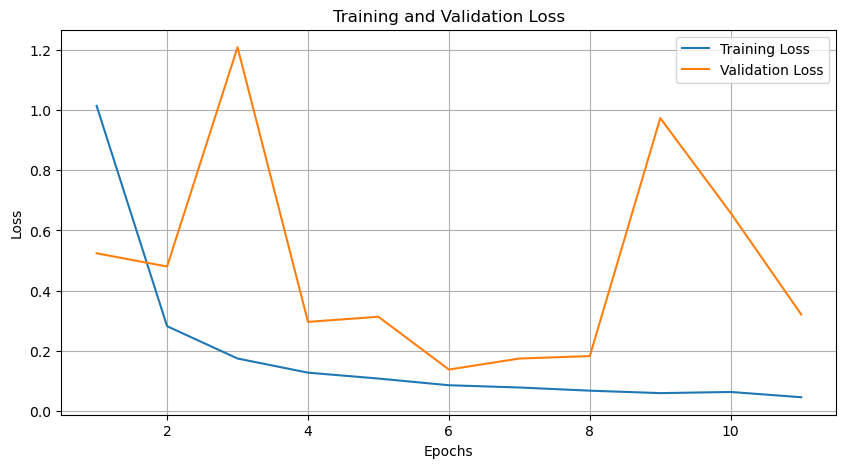

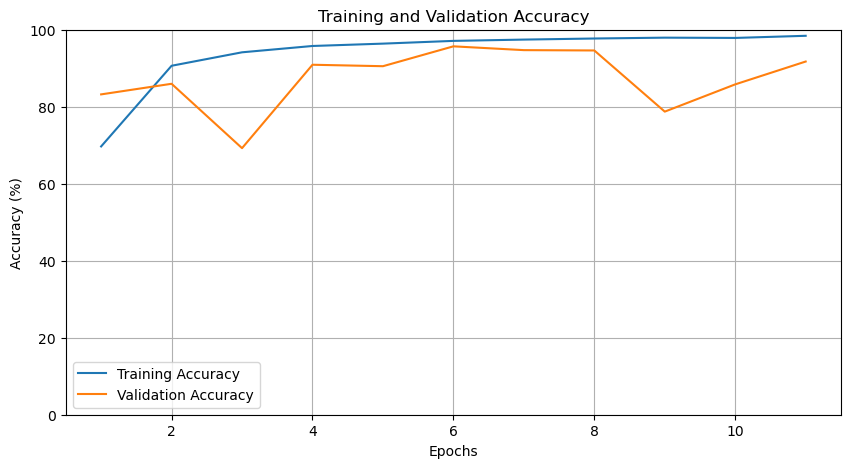

In [14]:
plot_training_history(history)

### Reduction 32

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv3_cbam_32.parameters(), lr=0.001)

In [16]:
from utils import plot_training_history, train_model
num_epochs = 100
history = train_model(mobilenetv3_cbam_32, train_loader, val_loader, num_epochs, criterion, optimizer, device="mps")

Epoch 1/100: 100%|██████████| 673/673 [09:00<00:00,  1.25batch/s]


Epoch [1/100], Train Loss: 0.8898, Train Accuracy: 73.21%, Val Loss: 0.3735, Val Accuracy: 87.79%
Checkpoint saved to checkpoints/best_model_epoch_1.pth


Epoch 2/100: 100%|██████████| 673/673 [10:33<00:00,  1.06batch/s]


Epoch [2/100], Train Loss: 0.2718, Train Accuracy: 91.06%, Val Loss: 0.2964, Val Accuracy: 89.97%
Checkpoint saved to checkpoints/best_model_epoch_2.pth


Epoch 3/100: 100%|██████████| 673/673 [12:14<00:00,  1.09s/batch]


Epoch [3/100], Train Loss: 0.1770, Train Accuracy: 94.06%, Val Loss: 0.3498, Val Accuracy: 89.26%


Epoch 4/100: 100%|██████████| 673/673 [11:38<00:00,  1.04s/batch]


Epoch [4/100], Train Loss: 0.1334, Train Accuracy: 95.53%, Val Loss: 0.9916, Val Accuracy: 75.46%


Epoch 5/100: 100%|██████████| 673/673 [12:05<00:00,  1.08s/batch]


Epoch [5/100], Train Loss: 0.1117, Train Accuracy: 96.36%, Val Loss: 0.1870, Val Accuracy: 93.85%
Checkpoint saved to checkpoints/best_model_epoch_5.pth


Epoch 6/100: 100%|██████████| 673/673 [11:50<00:00,  1.06s/batch]


Epoch [6/100], Train Loss: 0.0906, Train Accuracy: 96.97%, Val Loss: 0.1435, Val Accuracy: 95.37%
Checkpoint saved to checkpoints/best_model_epoch_6.pth


Epoch 7/100: 100%|██████████| 673/673 [10:53<00:00,  1.03batch/s]


Epoch [7/100], Train Loss: 0.0785, Train Accuracy: 97.36%, Val Loss: 0.3788, Val Accuracy: 88.53%


Epoch 8/100: 100%|██████████| 673/673 [11:11<00:00,  1.00batch/s]


Epoch [8/100], Train Loss: 0.0729, Train Accuracy: 97.51%, Val Loss: 0.0876, Val Accuracy: 97.18%
Checkpoint saved to checkpoints/best_model_epoch_8.pth


Epoch 9/100: 100%|██████████| 673/673 [10:39<00:00,  1.05batch/s]


Epoch [9/100], Train Loss: 0.0628, Train Accuracy: 97.85%, Val Loss: 0.1779, Val Accuracy: 93.97%


Epoch 10/100: 100%|██████████| 673/673 [12:16<00:00,  1.09s/batch]


Epoch [10/100], Train Loss: 0.0586, Train Accuracy: 98.09%, Val Loss: 0.1321, Val Accuracy: 95.74%


Epoch 11/100: 100%|██████████| 673/673 [10:59<00:00,  1.02batch/s]


Epoch [11/100], Train Loss: 0.0546, Train Accuracy: 98.20%, Val Loss: 0.0891, Val Accuracy: 97.00%


Epoch 12/100: 100%|██████████| 673/673 [10:44<00:00,  1.04batch/s]


Epoch [12/100], Train Loss: 0.0421, Train Accuracy: 98.50%, Val Loss: 0.3054, Val Accuracy: 91.20%


Epoch 13/100: 100%|██████████| 673/673 [10:12<00:00,  1.10batch/s]


Epoch [13/100], Train Loss: 0.0507, Train Accuracy: 98.31%, Val Loss: 0.1757, Val Accuracy: 94.60%
Early stopping triggered!
Training completed in: 157m 47s


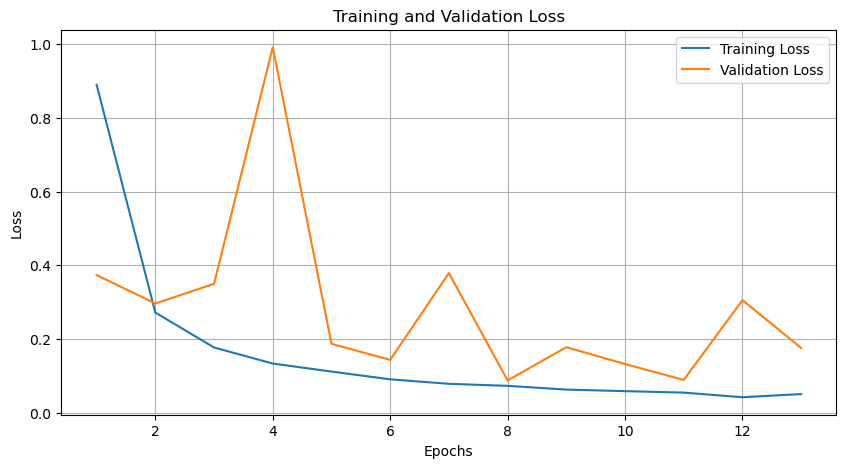

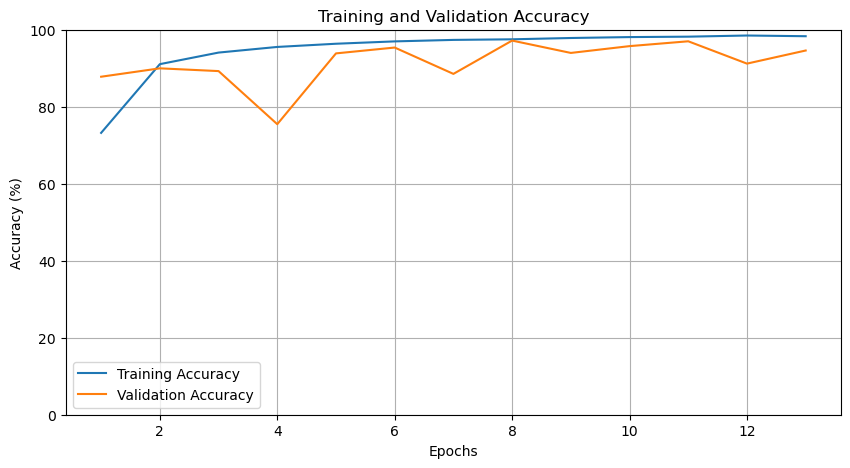

In [17]:
plot_training_history(history)

# Evaluation

In [11]:
from utils import evaluate_model

# Access the classes from the underlying dataset
class_names = test_loader.dataset.dataset.classes
print("Class Names:", class_names)

Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yel

## MobileNet V1

In [45]:
# Load model

loaded_model_v0 = MobileNetV1(ch_in=3, n_classes=num_classes)
loaded_model_v0.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/224x224/mobilenetv1.pth', map_location="mps"))
loaded_model_v0

MobileNetV1(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(1, 1

In [ ]:
cm, performance_table = evaluate_model(loaded_model_v0, test_loader, class_names)

In [ ]:
performance_table

### Inference Time

In [47]:
from evaluations import measure_throughput_latency

avg_latency, throughput = measure_throughput_latency(loaded_model_v0, test_loader, device='cpu')

print(f"Average Latency: {avg_latency:.4f} seconds per batch")
print(f"Throughput: {throughput:.2f} samples per second")

Average Latency: 2.9623 seconds per batch
Throughput: 21.47 samples per second


In [ ]:
from utils import calculate_inference_time

mobilenetv1_avg_time = calculate_inference_time(loaded_model_v0, test_loader)
print(f"Average Inference Time per Batch: {mobilenetv1_avg_time:.2f} ms")

## MobileNet V3 Large

In [51]:
# Load model

loaded_mobilenetv3_large = models.mobilenet_v3_large(num_classes=num_classes)
loaded_mobilenetv3_large.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/224x224/mobilenetv3_large.pth', map_location="mps"))
loaded_mobilenetv3_large

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(loaded_mobilenetv3_large, criterion, test_loader, class_names, device='mps')

In [ ]:
performance_table

### Inference Time

In [52]:
from evaluations import measure_throughput_latency

avg_latency, throughput = measure_throughput_latency(loaded_mobilenetv3_large, test_loader, device='cpu')

print(f"Average Latency: {avg_latency:.4f} seconds per batch")
print(f"Throughput: {throughput:.2f} samples per second")

Average Latency: 3.1378 seconds per batch
Throughput: 20.27 samples per second


In [ ]:
from utils import calculate_inference_time

mobilenetv3_avg_time = calculate_inference_time(loaded_mobilenetv3_large, test_loader)
print(f"Average Inference Time per Batch: {mobilenetv3_avg_time:.2f} ms")

## MobileNet V3 Small

In [12]:
# Load model

loaded_mobilenetv3_small = models.mobilenet_v3_small(num_classes=num_classes)
loaded_mobilenetv3_small.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/224x224/mobilenetv3_small.pth', map_location="mps"))
loaded_mobilenetv3_small

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(loaded_mobilenetv3_small, criterion, test_loader, class_names, device=device)

In [13]:
from evaluations import measure_throughput_latency

avg_latency, throughput = measure_throughput_latency(loaded_mobilenetv3_small, test_loader, device='cpu')

print(f"Average Latency: {avg_latency:.4f} seconds per batch")
print(f"Throughput: {throughput:.2f} samples per second")

Average Latency: 1.2680 seconds per batch
Throughput: 50.17 samples per second


In [ ]:
from utils import calculate_inference_time

mobilenetv3_small_avg_time = calculate_inference_time(loaded_mobilenetv3_small, test_loader)
print(f"Average Inference Time per Batch: {mobilenetv3_small_avg_time:.2f} ms")

## SqueezeNet

In [25]:
loaded_squeezenet = models.squeezenet.SqueezeNet(num_classes=num_classes)
loaded_squeezenet.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/squeezenet.pth', map_location="mps"))
loaded_squeezenet

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

Final Loss: 51.1328


/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


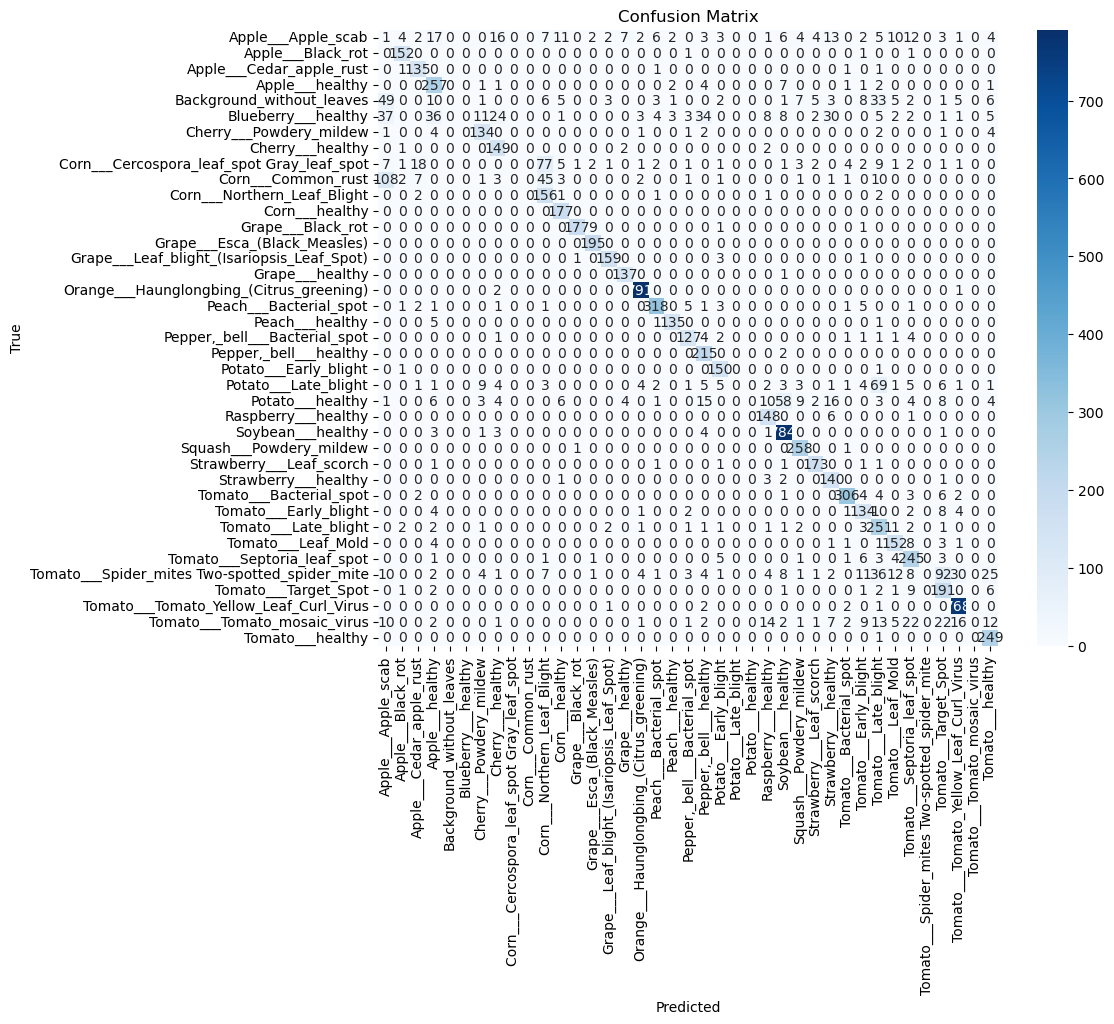

Accuracy: 0.80
Precision: 0.70
Recall: 0.80
F1 Score: 0.7410


In [26]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(squeezenet, criterion, test_loader, class_names, device=device)

### Inference Time

In [22]:
from evaluations import measure_throughput_latency

avg_latency, throughput = measure_throughput_latency(loaded_squeezenet, test_loader, device='cpu')

print(f"Average Latency: {avg_latency:.4f} seconds per batch")
print(f"Throughput: {throughput:.2f} samples per second")

Average Latency: 1.6975 seconds per batch
Throughput: 37.47 samples per second


## ShuffleNetV2

### Inference Time

In [12]:
# Load model

loaded_shufflenetv2 = models.shufflenet_v2_x1_0(num_classes=num_classes)
loaded_shufflenetv2.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/224x224/shufflenetv2.pth', map_location="mps"))
loaded_shufflenetv2

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

Final Loss: 3.6089


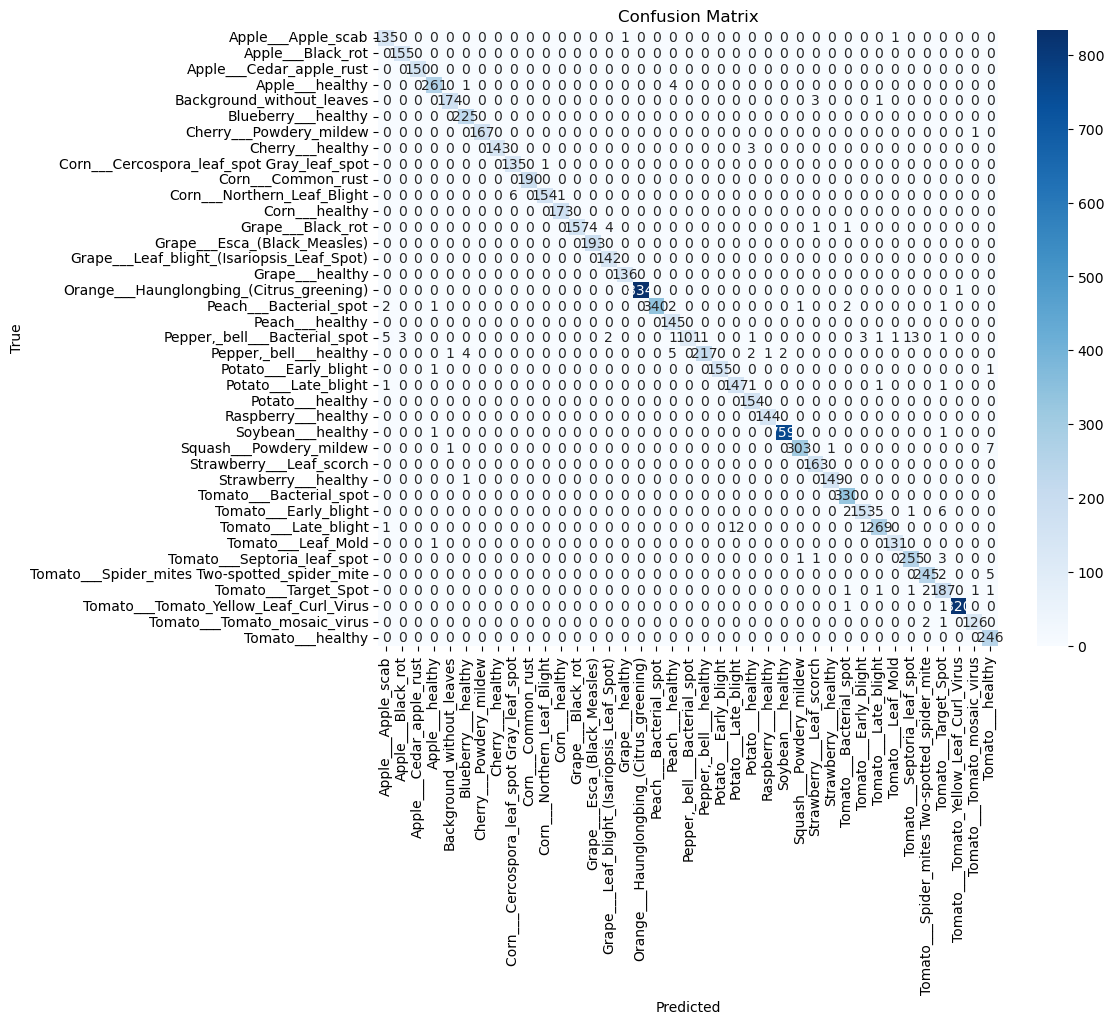

Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 Score: 0.9824


In [15]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(loaded_shufflenetv2, criterion, test_loader, class_names, device=device)

In [24]:
from evaluations import measure_throughput_latency

avg_latency, throughput = measure_throughput_latency(loaded_shufflenetv2, test_loader, device='cpu')

print(f"Average Latency: {avg_latency:.4f} seconds per batch")
print(f"Throughput: {throughput:.2f} samples per second")

Average Latency: 1.1625 seconds per batch
Throughput: 54.72 samples per second


## MobileNetV3+CBAM Large

In [11]:
# Load model

loaded_mobilenetv3_cbam_large = MobileNetV3WithCBAM(mode='large', num_classes=num_classes)
loaded_mobilenetv3_cbam_large.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/mobilenetv3_cbam_large.pth', map_location="mps"))

<All keys matched successfully>

Final Loss: 7.9715


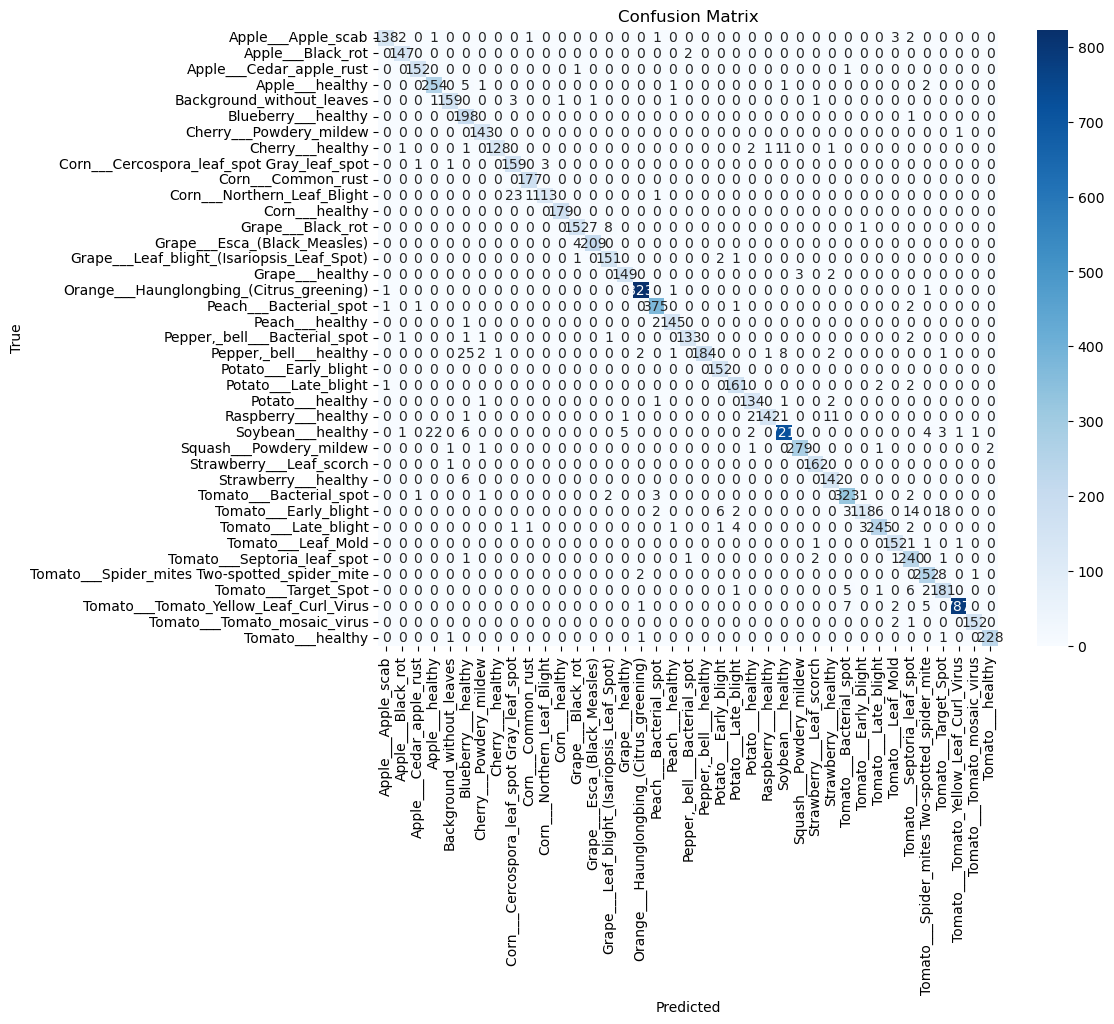

Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1 Score: 0.9580


In [18]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(loaded_mobilenetv3_cbam_large, criterion, test_loader, class_names, device=device)

In [12]:
from evaluations import measure_throughput_latency

avg_latency, throughput = measure_throughput_latency(loaded_mobilenetv3_cbam_large, test_loader, device='cpu')

print(f"Average Latency: {avg_latency:.4f} seconds per batch")
print(f"Throughput: {throughput:.2f} samples per second")

Average Latency: 1.8895 seconds per batch
Throughput: 33.67 samples per second


In [19]:
from utils import calculate_inference_time

mobilenetv3_cbam_large_avg_time = calculate_inference_time(loaded_mobilenetv3_cbam_large, test_loader)
print(f"Average Inference Time per Batch: {mobilenetv3_cbam_large_avg_time:.2f} ms")

Average Inference Time per Batch: 1813.23 ms


### Reduction 32

In [18]:
# Load model

loaded_mobilenetv3_cbam_32 = MobileNetV3WithCBAM(mode='large', num_classes=num_classes, reduction=32)
loaded_mobilenetv3_cbam_32.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/mobilenetv3_cbam_32.pth', map_location="mps"))

<All keys matched successfully>

Final Loss: 6.2401


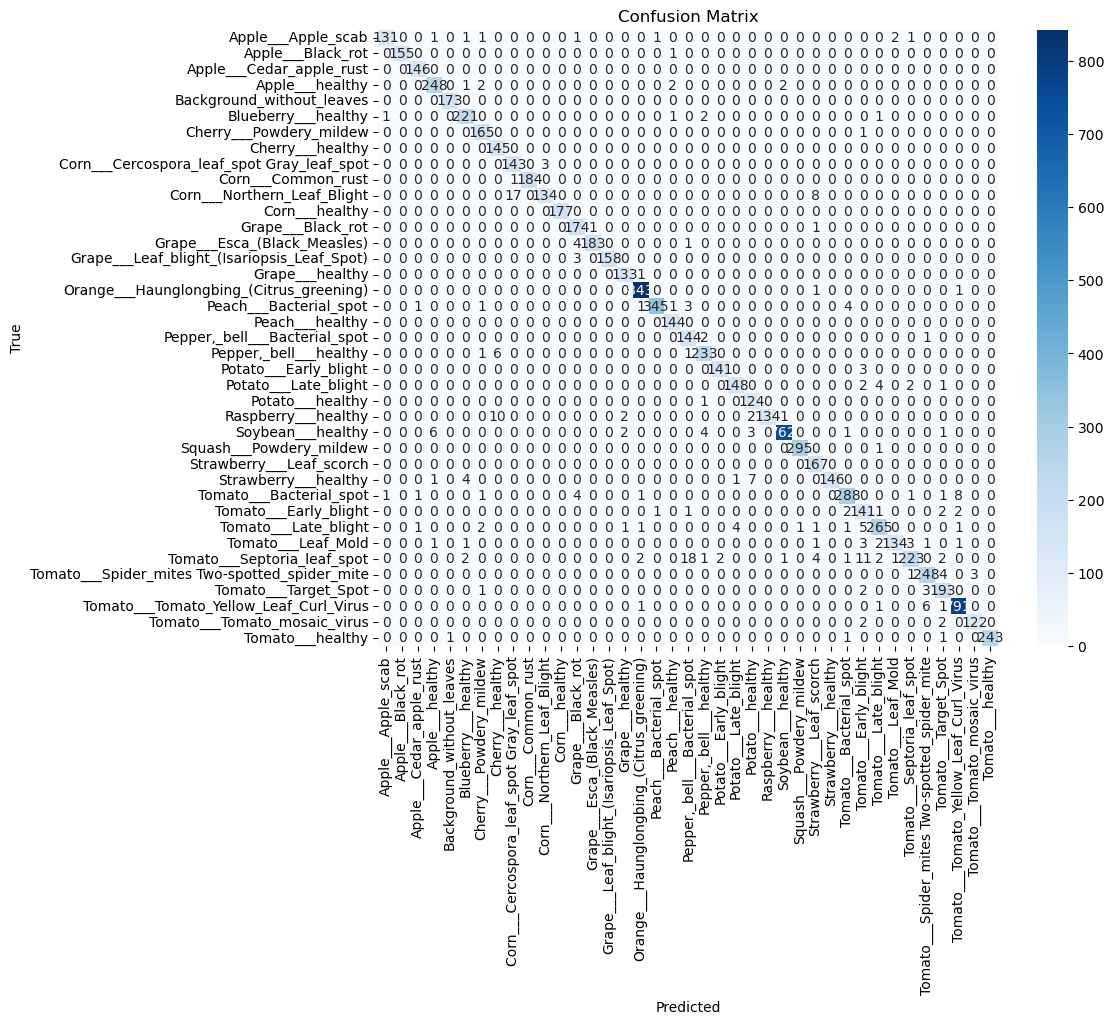

Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1 Score: 0.9696


In [19]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(loaded_mobilenetv3_cbam_32, criterion, test_loader, class_names, device=device)

In [20]:
from evaluations import measure_throughput_latency

avg_latency, throughput = measure_throughput_latency(loaded_mobilenetv3_cbam_32, test_loader, device='cpu')

print(f"Average Latency: {avg_latency:.4f} seconds per batch")
print(f"Throughput: {throughput:.2f} samples per second")

Average Latency: 1.7793 seconds per batch
Throughput: 35.75 samples per second


# Results

## Model Performance

In [31]:
import pandas as pd

mobilenetv1_results = {
    "model_name": "MobileNetV1",
    "accuracy": 0.97,
    "precision": 0.97,
    "recall": 0.97,
    "f1-score": 0.9731
}

mobilenetv3large_results = {
    "model_name": "MobileNetV3 Large",
    "accuracy": 0.93,
    "precision": 0.94,
    "recall": 0.93,
    "f1-score": 0.9326
}

mobilenetv3small_results = {
    "model_name": "MobileNetV3 Small",
    "accuracy": 0.95,
    "precision": 0.95,
    "recall": 0.95,
    "f1-score": 0.9467
}

mobilenetv2_result = {
    "model_name": "MobileNetV2",
    "accuracy": None,
    "precision": None,
    "recall": None,
    "f1-score": None
}

squeezenet_results = {
    "model_name": "SqueezeNet",
    "accuracy": 0.80,
    "precision": 0.70,
    "recall": 0.80,
    "f1-score": 0.7410
}

shufflenetv2_results = {
    "model_name": "ShuffleNetV2",
    "accuracy": 0.97,
    "precision": 0.97,
    "recall": 0.97,
    "f1-score": 0.9661
}

mobilenetv3_cbam_large_results = {
    "model_name": "MobileNetV3+CBAM 16",
    "accuracy": 0.96,
    "precision": 0.96,
    "recall": 0.96,
    "f1-score": 0.9580
}

mobilenetv3_cbam_32_results = {
    "model_name": "MobileNetV3+CBAM 32",
    "accuracy": 0.97,
    "precision": 0.97,
    "recall": 0.97,
    "f1-score": 0.9696
}

In [32]:
compare_results = pd.DataFrame([mobilenetv3large_results, 
                                mobilenetv3small_results, 
                                squeezenet_results, 
                                shufflenetv2_results,
                                mobilenetv3_cbam_large_results,
                                mobilenetv3_cbam_32_results])
compare_results

,model_name,accuracy,precision,recall,f1-score
0,MobileNetV3 Large,0.93,0.94,0.93,0.9326
1,MobileNetV3 Small,0.95,0.95,0.95,0.9467
2,SqueezeNet,0.80,0.70,0.80,0.7410
3,ShuffleNetV2,0.97,0.97,0.97,0.9661
4,MobileNetV3+CBAM 16,0.96,0.96,0.96,0.9580
5,MobileNetV3+CBAM 32,0.97,0.97,0.97,0.9696


## Model Complexity

In [35]:
import pandas as pd

mobilenetv1_complex = {
    "model_name": "MobileNetV1",
    "FLOPs": f"{588_000_000 / 1_000_000:.1f}M",
    "MACs": f"{294_015_000 / 1_000_000:.1f}M",
    "Params" : f"{3_250_000 / 1000:.1f}K",
    "training (minutes)": 200,
    "average_latency (seconds/batch)": 2.9623,
    "throughput (samples/s)": 21.47,
    "model_size": 5215.26
}

mobilenetv2_complex = {
    "model_name": "MobileNetV2",
    "FLOPs": f"{319_070_000 / 1_000_000:.1f}M",
    "MACs": f"{319_070_000 / 2 / 1000000:.1f}M",
    "Params" : f"{2_270_000 / 1000:.1f}K",
    "training (minutes)": None,
    "average_latency (seconds/batch)": None,
    "throughput (samples/s)": 0,
    "model_size": 6886.04
}

mobilenetv3_large_complex = {
    "model_name": "MobileNetv3 Large",
    "FLOPs": f"{230_090_000 / 1_000_000:.1f}M",
    "MACs": f"{230_090_000 / 2 / 1000000:.1f}M",
    "Params": f"{4_250_000 / 1000:.1f}K",
    "training (minutes)": 224,
    "average_latency (seconds/batch)": 3.1378,
    "throughput (samples/s)": 20.27,
    "model_size": 4564.22
}

mobilenetv3_small_complex = {
    "model_name": "MobileNetV3 Small",
    "FLOPs": f"{59_930_000 / 1_000_000:.1f}M",
    "MACs": f"{59_930_000 / 2 / 1000000:.1f}M",
    "Params": f"{1_560_000 / 1000:.1f}K",
    "training (minutes)": 127,
    "average_latency (seconds/batch)": 1.2680,
    "throughput (samples/s)": 50.17,
    "model_size": 1493.46
}

squeezenet_complex = {
    "model_name": "SqueezeNet",
    "FLOPs": f"{752_860_000 / 1_000_000:.1f}M",
    "MACs": f"{752_860_000 / 2 / 1000000:.1f}M",
    "Params": f"{755_430 / 1000:.1f}K",
    "training (minutes)": 161,
    "average_latency (seconds/batch)": 1.6975,
    "throughput (samples/s)": 37.47,
    "model_size": 2183.68
}

shufflenetv2_complex = {
    "model_name": "ShuffleNetV2",
    "FLOPs": f"{151_400_000 / 1_000_000:.1f}M",
    "MACs": f"{151_400_000 / 2 / 1000000:.1f}M",
    "Params": f"{1_290_000 / 1000:.1f}K",
    "training (minutes)": 159,
    "average_latency (seconds/batch)": 1.1625,
    "throughput (samples/s)": 54.72,
    "model_size": 2040.73
}

mobilenetv3_cbam_large_complex = {
    "model_name": "MobileNetV3+CBAM 16",
    "FLOPs": f"{162_580_000 / 1_000_000:.1f}M",
    "MACs": f"{164_430_000 / 2 / 1000000:.1f}M",
    "Params": f"{1_020_000 / 1000:.1f}K",
    "training (minutes)": 125,
    "average_latency (seconds/batch)": 1.813,
    "throughput (samples/s)": 33.67,
    "model_size": 3876.82
}

mobilenetv3_cbam_32_complex = {
    "model_name": "MobileNetV3+CBAM 32",
    "FLOPs": f"{162_580_000 / 1_000_000:.1f}M",
    "MACs": f"{164_430_000 / 2 / 1000000:.1f}M",
    "Params": f"{1_020_000 / 1000:.1f}K",
    "training (minutes)": 157,
    "average_latency (seconds/batch)": 1.7793,
    "throughput (samples/s)": 35.75,
    "model_size": 3876.77
}

In [36]:
compare_complex = pd.DataFrame([
                                mobilenetv2_complex, 
                                mobilenetv3_large_complex, 
                                mobilenetv3_small_complex, 
                                squeezenet_complex, 
                                shufflenetv2_complex,
                                mobilenetv3_cbam_large_complex,
                                mobilenetv3_cbam_32_complex])
compare_complex

,model_name,FLOPs,MACs,Params,training (minutes),average_latency (seconds/batch),throughput (samples/s),model_size
0,MobileNetV2,319.1M,159.5M,2270.0K,NaN,NaN,0.00,6886.04
1,MobileNetv3 Large,230.1M,115.0M,4250.0K,224.0,3.1378,20.27,4564.22
2,MobileNetV3 Small,59.9M,30.0M,1560.0K,127.0,1.2680,50.17,1493.46
3,SqueezeNet,752.9M,376.4M,755.4K,161.0,1.6975,37.47,2183.68
4,ShuffleNetV2,151.4M,75.7M,1290.0K,159.0,1.1625,54.72,2040.73
5,MobileNetV3+CBAM 16,162.6M,82.2M,1020.0K,125.0,1.8130,33.67,3876.82
6,MobileNetV3+CBAM 32,162.6M,82.2M,1020.0K,157.0,1.7793,35.75,3876.77
